# Proyecto final: Análisis descriptivo, predictivo y prescriptivo sobre el precio del oro

¡Bienvenido! En este proyecto podrás hacer por ti mismo lo que has estudiado en el curso, que ya viste de forma práctica en los ejemplos. Utiliza las consignas que están en cada celda para saber paso a paso qué hacer. ¡Buena suerte! 


Nota: En caso de que estés trabajando en R, las librerías, funciones y quizás la orden de algunas líneas de código pueden variar.

In [27]:
library(descr)
library(magrittr)
library(dplyr)
library(gplots)
library(ggplot2)
library(GGally)
library(Metrics)
library(party)
library(caTools)
library(randomForest)
library(xgboost)

# Parte 1: Análisis descriptivo

## Leer los datos

Después de importar las librerías descarga el archivo "gld_price_data.csv" y "gold_test.csv", que puedes encontrar en los adjuntos del curso y guárdalos dentro de la misma carpeta donde se encuentre este código. En la siguiente línea importa los datos en "gld_price_data.csv" y guárdalos en un dataframe llamado df. Recuerda escribir el directorio exactamente como está en tu sistema. 

In [51]:
df <- read.csv("./data/gld_price_data.csv")

La siguiente información, muestra el significado de las columnas:
- SPX: índice de capitalización de las 500 mayores empresas cotizadas en EE.UU
- SLV: precio de la plata
- USO: precio del petróleo en EE.UU
- GLD: precio del oro
- EUR/USD: razón entre precio de euros y dólares.

Usa las funciones correspondientes para observar las primeras filas de la base de datos, y para saber cuántas filas y columnas tiene. A continuación, define la variable objetivo, en este caso queremos usar los datos para predecir el precio del oro "GLD".

In [29]:
head(df)

Date     SPX     GLD   USO   SLV    EUR.USD 
1 1/2/2008 1447.16 84.86 78.47 15.180 1.471692
2 1/3/2008 1447.16 85.57 78.37 15.285 1.474491
3 1/4/2008 1411.63 85.13 77.31 15.167 1.475492
4 1/7/2008 1416.18 84.77 75.50 15.053 1.468299
5 1/8/2008 1390.19 86.78 76.06 15.590 1.557099
6 1/9/2008 1409.13 86.55 75.25 15.520 1.466405

In [30]:
dim(df)

[1] 2290    6

In [31]:
target = 'GLD' # Completa con el nombre de la variable objetivo

A continuación, veamos algunas estadísticas descriptivas de las columnas de df.

In [32]:
descr(df)


Date
   Length     Class      Mode 
     2290 character character 

SPX
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  676.5  1239.9  1551.4  1654.3  2073.0  2872.9 

GLD
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   70.0   109.7   120.6   122.7   132.8   184.6 

USO
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7.96   14.38   33.87   31.84   37.83  117.48 

SLV
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8.85   15.57   17.27   20.09   22.88   47.26 

EUR.USD
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.039   1.171   1.303   1.284   1.370   1.599 


## Preprocesamiento
Primero, elimina la columna "Date" que por el momento no nos aporta información. A continuación completa el código para eliminar las columnas con más de 80% de datos faltantes

In [33]:
df <- subset(df, select = -Date)

In [34]:
df <- Filter(function(df) mean(is.na(df)) < 0.8, df)
cat('Cantidad de columnas restantes en df:',ncol(df)) # Completar

Cantidad de columnas restantes en df: 5

Busquemos y eliminemos ahora filas duplicadas. 

In [35]:
df <- distinct(df) # Código para eliminar duplicados
nrow(df)

[1] 2290

Como vemos no hay datos nulos ni duplicados en esta base, por lo tanto no se eliminarán columnas, ni tampoco necesitaremos hacer imputación. Además, todas las variables de nuestra base son numéricas como se puede ver en la descripción.

### Outliers 
Como viste en los ejemplos, construye una tabla (dataframe) con la siguiente información: 
- Primer y tercer cuartil
- Rango intercuartílico
- Outliers superiores, es decir, aquellos valores que son mayores que tercer_cuartil+1.5*iqr
- Outliers inferiores, es decir, aquellos valores que son menores que primer_cuartil-1.5*iqr

Además, crea una lista con los índices que contengan valores menores que el límite inferior o mayores que el límite superior.

In [36]:
dfcolumns <- colnames(df)
tabla <- as.data.frame(matrix(nrow=ncol(df),ncol=5))
colnames(tabla) <- c('Primer cuartil','Tercer cuartil', 'IQR','Outliers_Sup','Outliers_Inf')
rownames(tabla) <- dfcolumns
for(i in 1:ncol(df)) { 
    col = dfcolumns[i]
    tabla[col,'Primer cuartil'] <- quantile(df[,col], probs=0.25)
    tabla[col,'Tercer cuartil'] <- quantile(df[,col], probs=0.75)
    tabla[col,'IQR'] <- IQR(df[,col])
    lim_sup = tabla[col,'Tercer cuartil']+tabla[col,'IQR']*1.5
    lim_inf = tabla[col,'Primer cuartil']-tabla[col,'IQR']*1.5
    tabla[col,'Outliers_Sup'] <- sum(df[,col]>lim_sup, na.rm=TRUE)
    tabla[col,'Outliers_Inf'] <- sum(df[,col]<lim_inf, na.rm=TRUE)    
}
            # Completar con el código para producir una tabla como en los ejemplos.
tabla

Primer cuartil Tercer cuartil IQR         Outliers_Sup Outliers_Inf
SPX     1239.874969    2073.010070    833.1351012   0           0          
GLD      109.725000     132.840004     23.1150038  92          23          
USO       14.380000      37.827501     23.4475015 134           0          
SLV       15.570000      22.882499      7.3124995 117           0          
EUR.USD    1.171313       1.369971      0.1986577   0           0

Si la cantidad de outliers es menor que el 20% (debe ser el caso), elimínalos y ve cuántas columnas quedaron en df. 

In [37]:
for(i in 1:ncol(df)){
    col = dfcolumns[i]
    tabla[col,'Primer cuartil'] <- quantile(df[,col], probs=0.25)
    tabla[col,'Tercer cuartil'] <- quantile(df[,col], probs=0.75)
    tabla[col,'IQR'] <- IQR(df[,col])
    lim_sup = tabla[col,'Tercer cuartil']+tabla[col,'IQR']*1.5
    lim_inf = tabla[col,'Primer cuartil']-tabla[col,'IQR']*1.5

    df <- filter(df,df[,col]<=lim_sup)
    df <- filter(df,df[,col]>=lim_inf)
}
dim(df)

[1] 1909    5

Visualizaciones
Veamos paso a paso cómo se comportan nuestras variables.

Utiliza la función o las funciones convenientes para realizar un scatter plot de las columnas dos a dos, y las gráficas de histogramas y/o densidad de las columnas.

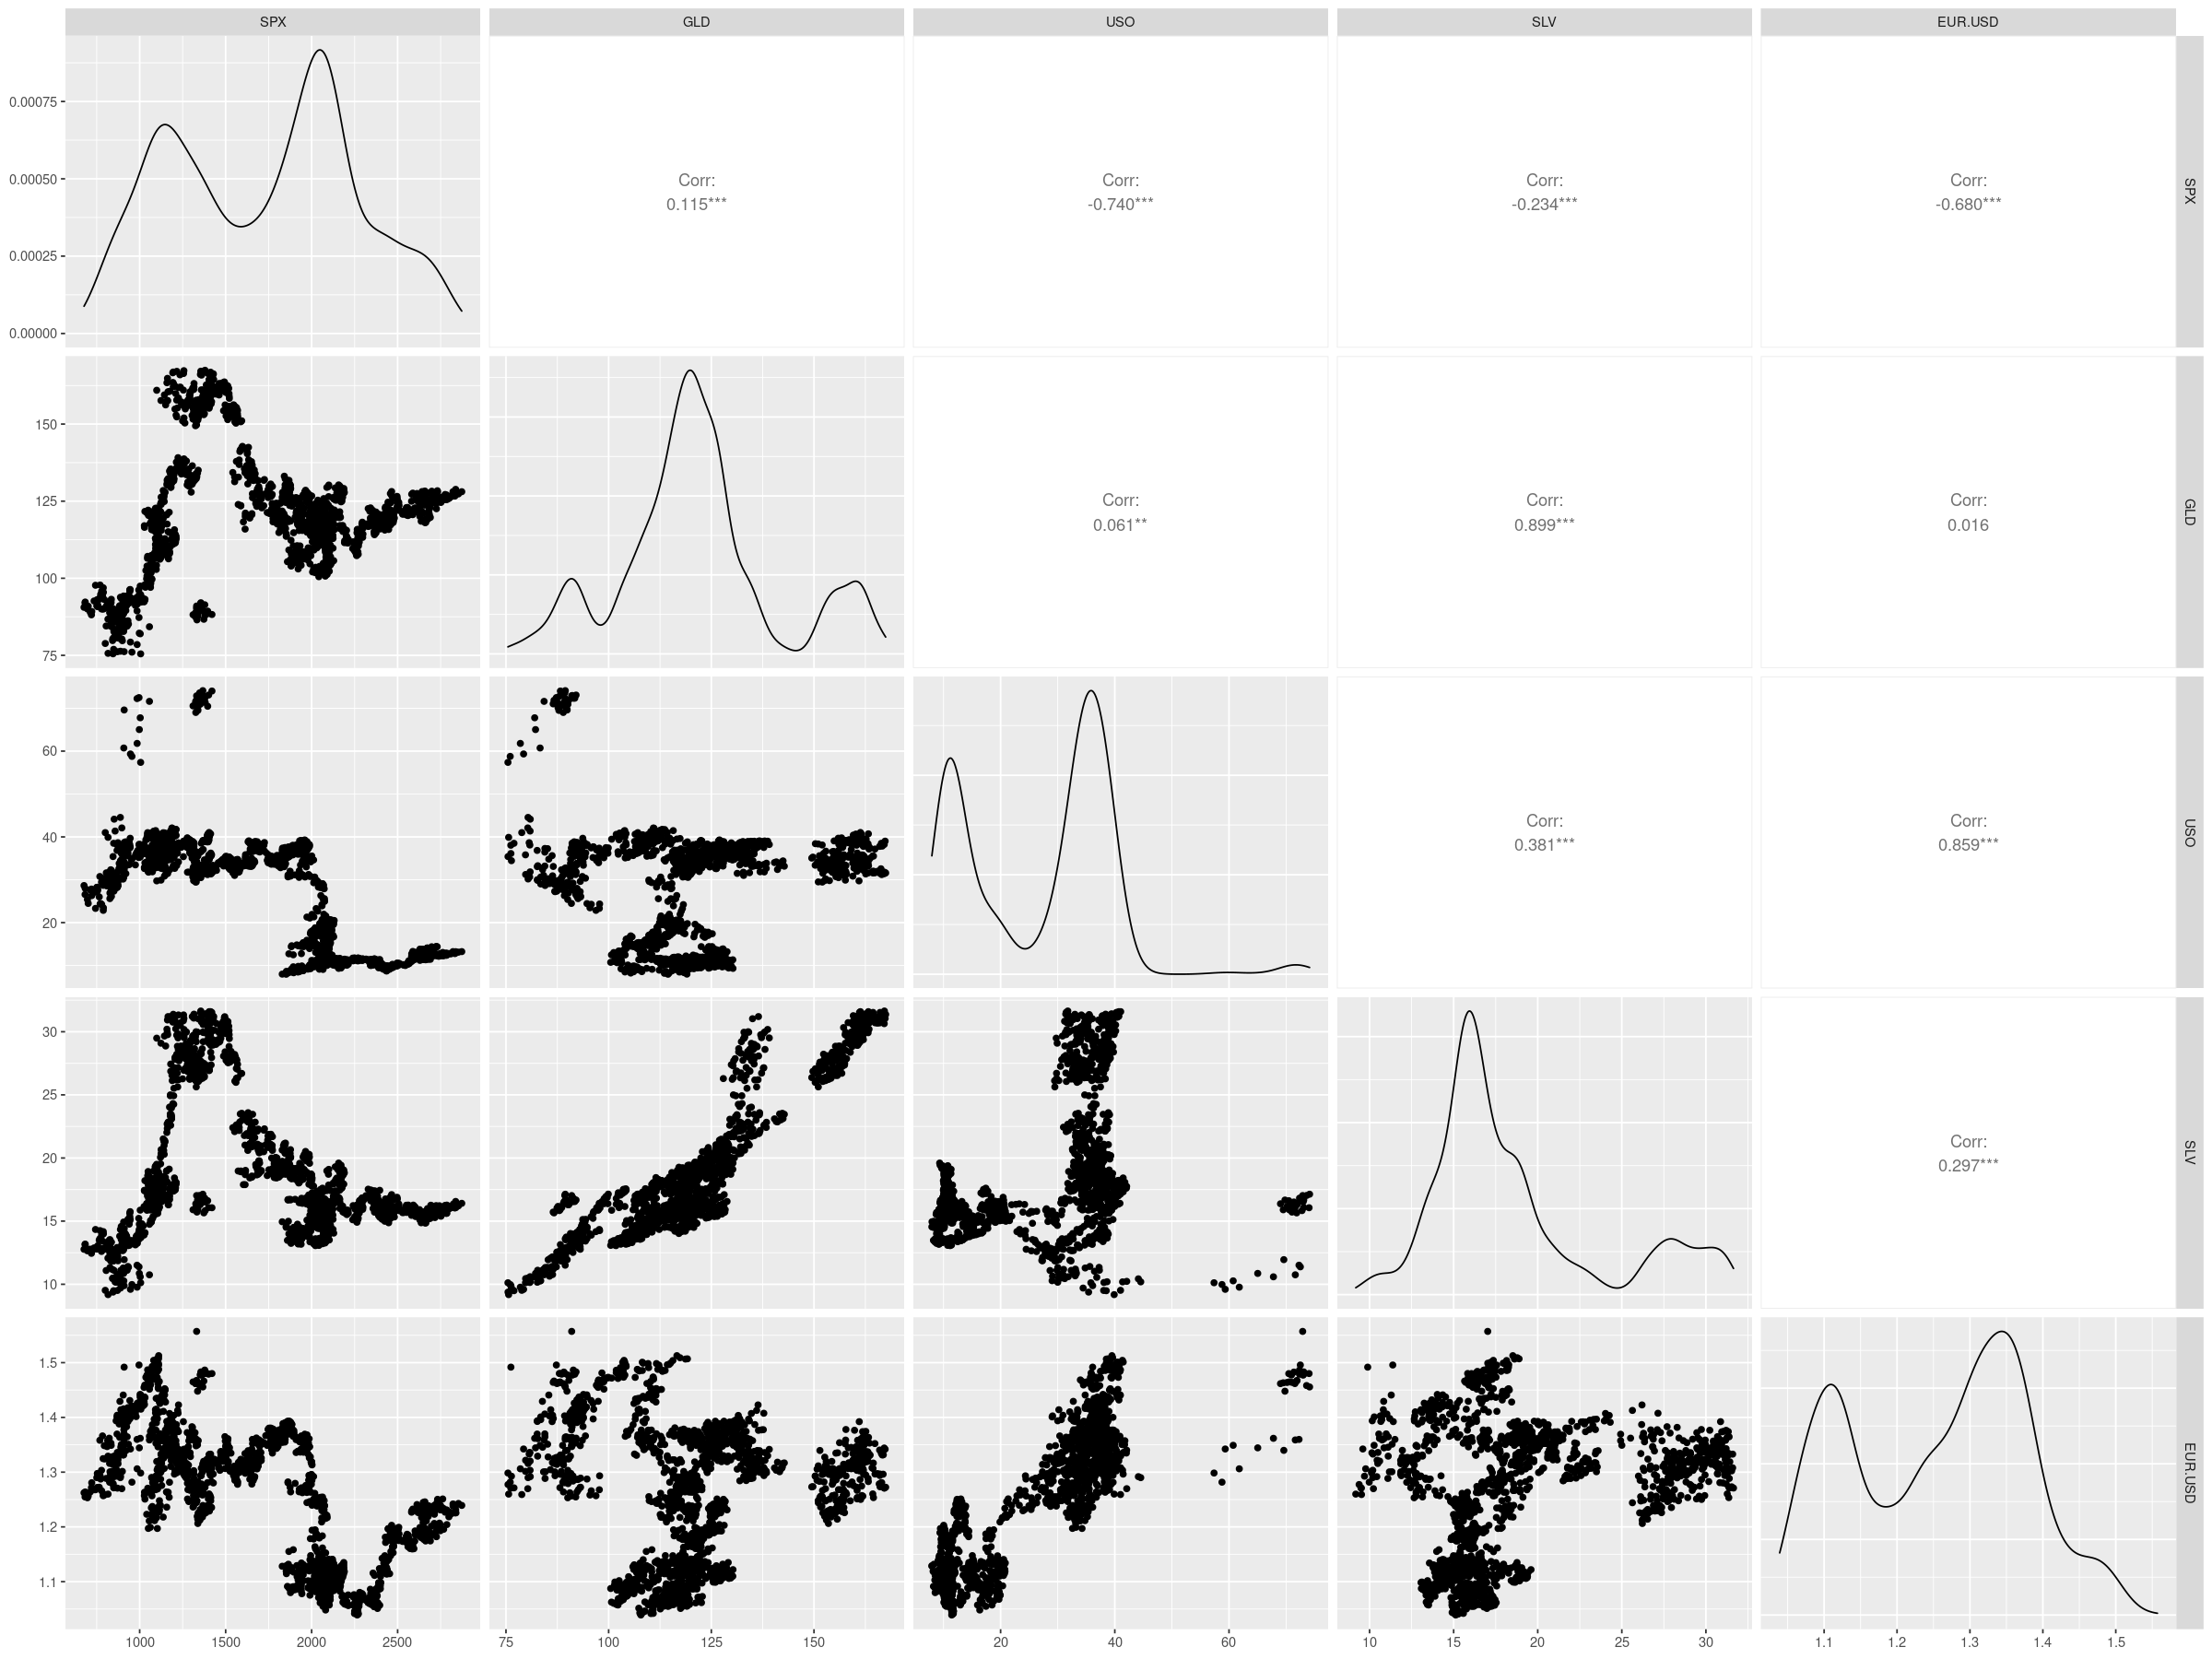

In [38]:
options(repr.plot.width=20, repr.plot.height=15)
ggpairs(df)


### Correlación
En los gráficos de dispersión (scatter plot) se puede ver una correlación entre algunas de las variables, halla la matriz de correlación  y construye una gráfica de calor (heatmap). 

Sugerencia: Puedes utilizar la función corr() de pandas en Python o la función cor() de R para hallar la correlación y la función heatmap para graficar. 

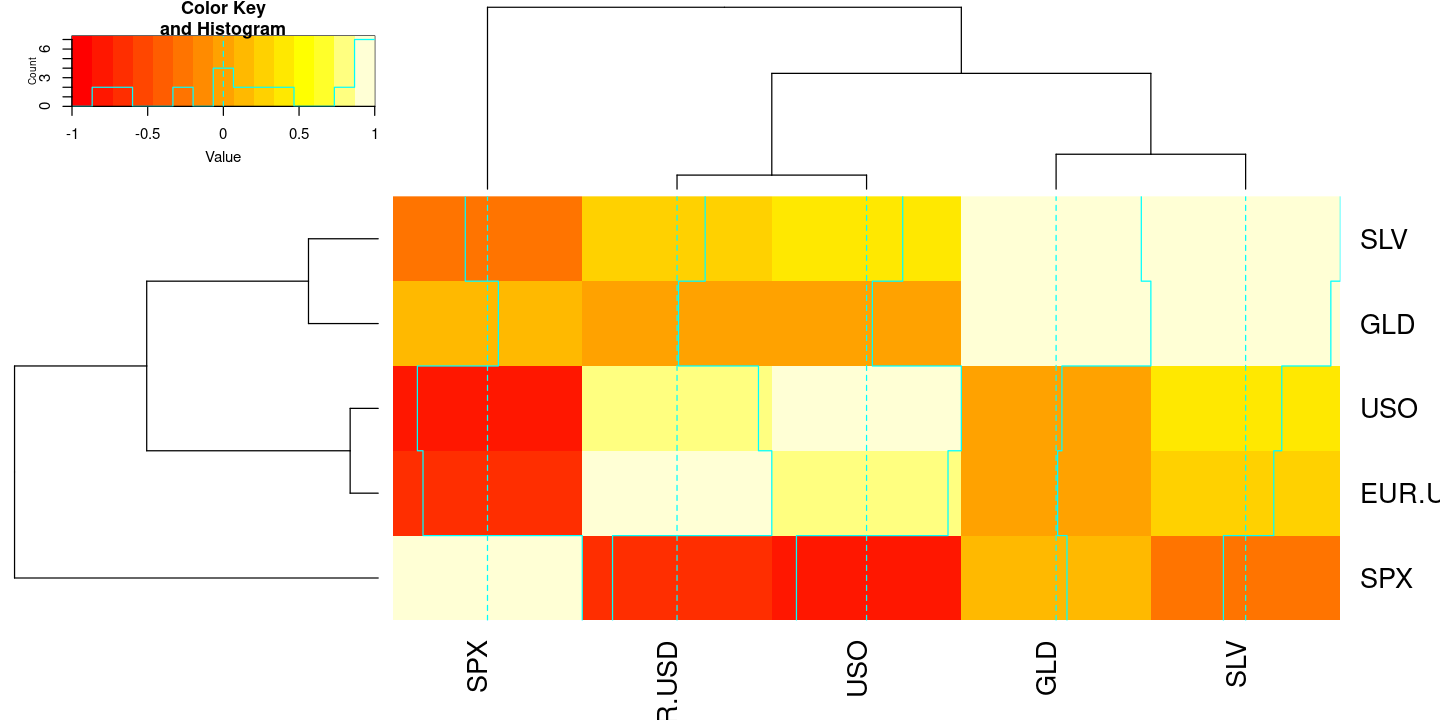

In [39]:
options(repr.plot.width=12, repr.plot.height=6)
heatmap.2(cor(df))


# Parte 2: Entrenamiento de modelos y predicción

## Entrenamiento y evaluación
Divide los datos en subconjuntos de entrenamiento y prueba como viste en los ejemplos. 
Entrena los modelos vistos en los ejemplos, **Regresión Lineal**, **Random Forest**, **Gradient Boosting**  con un subconjunto de los datos y realiza predicciones en el conjunto de prueba. Halla la precisión de estos hallando el R cuadrado.

In [40]:
# Separa los datos en conjuntos de entrenamiento y prueba como aprendiste en los ejemplos.

split <- sample.split(df, SplitRatio = 0.7)

train <- subset(df, split == "TRUE")
test <- subset(df, split == "FALSE")


In [41]:
# Regresión lineal
LR <- lm(GLD ~. , data = train)
y_pred = predict(LR, newdata = test[dfcolumns[dfcolumns!='GLD']])

R2 = cor(y_pred,test$GLD)^2
R2

[1] 0.9281744

In [42]:
# Random Forest
set.seed(120)  # Setting seed
RF = randomForest(x = train[dfcolumns[dfcolumns!='GLD']],
                             y = train$GLD,
                             ntree = 500)
y_pred = predict(RF, newdata = test[dfcolumns[dfcolumns!='GLD']])

R2 = cor(y_pred,test$GLD)^2
R2

[1] 0.9826061

In [43]:
# Gradient Boosting

x_train <- data.matrix(train[dfcolumns[dfcolumns!='GLD']])
y_train <- train$GLD

x_test <- data.matrix(test[dfcolumns[dfcolumns!='GLD']])
y_test <- test$GLD

xgb_train <- xgb.DMatrix(data = x_train, label = y_train)
xgb_test <- xgb.DMatrix(data = x_test, label = y_test)


xgb <- xgboost(data = xgb_train, nrounds = 100, verbose = 0)
y_pred = predict(xgb, xgb_test)

R2 = cor(y_pred,test$GLD)^2
R2

[1] 0.9832434

#### Conclusiones
¿Cuál es el mejor en cuanto a la medida de R^2?

In [44]:
print('El modelo que presenta mejor precisión es --- ') #Completar

[1] "El modelo que presenta mejor precisión es --- "


### Predicción
Carga los archivos en "gold_test.csv" en un dataframe llamado "df_test" y utilizando el modelo que elegiste en la celda anterior realiza una predicción con los nuevos datos, agrégala como una nueva columna llamada "Price" a "df_test" e imprime tu nuevo dataframe.

In [45]:
df_test = read.csv('./data/gold_test.csv')
RF_pred =  predict(RF, df_test)
df_test['Price'] = RF_pred
df_test

Date       SPX     USO   SLV    EUR.USD  Price    
1    9/18/2014  2011.36 34.62 17.77  1.292006 119.11972
2    9/16/2010  1124.66 32.98 20.35  1.307600 124.83836
3    6/20/2016  2083.25 11.91 16.65  1.132298 121.18423
4    6/4/2015   2095.84 19.66 15.48  1.120787 114.78643
5    3/25/2013  1551.69 33.85 27.84  1.302406 154.22133
6    11/27/2013 1807.23 33.19 18.96  1.356779 119.99223
7    7/6/2009    898.72 34.71 13.10  1.391595  91.46971
8    2/9/2016   1852.21  8.18 14.51  1.118981 115.58919
9    10/29/2013 1771.95 35.41 21.69  1.378930 128.05451
10   9/1/2016   2170.86 10.06 17.94  1.120072 125.74402
11   3/14/2014  1841.13 35.53 20.62  1.386539 130.08215
12   6/8/2017   2433.79  9.43 16.49  1.118481 120.42890
13   2/21/2018  2701.33 12.29 15.54  1.233532 125.65012
14   2/12/2013  1519.43 35.28 30.09  1.340357 156.99350
15   10/20/2016 2141.34 11.43 16.64  1.093040 120.04461
16   2/13/2009   826.84 25.60 13.54  1.286604  91.86763
17   4/10/2013  1587.73 33.83 26.68  1.305534 149.31990
18   11/1/2013  1761.64 34.13 21.08  1.357976 127.10377
19   8/11/2015  2084.07 14.48 14.64  1.104204 107.83387
20   3/7/2008   1293.37 83.73 20.04  1.533601  99.09899
21   3/10/2010  1145.61 39.90 16.66  1.364331 109.18774
22   10/1/2013  1695.00 36.68 20.41  1.352338 126.17883
23   3/19/2010  1159.90 39.20 16.65  1.353693 109.16491
24   1/26/2015  2057.09 16.87 17.13  1.112545 121.53312
25   2/2/2009    825.44 28.40 12.21  1.281493  88.76693
26   9/15/2010  1125.07 33.49 20.17  1.301507 124.19955
27   3/22/2012  1392.78 40.14 30.54  1.321877 160.07694
28   9/17/2012  1461.19 35.75 32.99  1.311011 160.76179
29   10/27/2008  848.92 50.85  8.85  1.246463  81.67160
30   1/28/2013  1500.18 34.94 29.85  1.346602 157.31612
⋮    ⋮          ⋮       ⋮     ⋮      ⋮        ⋮        
1002 2/3/2010   1097.28 37.65 16.070 1.390105 108.76347
1003 9/12/2016  2159.04 10.64 18.170 1.124354 126.09863
1004 1/12/2016  1938.68  9.17 13.170 1.085800 104.76673
1005 10/16/2014 1862.76 31.10 16.670 1.280442 119.03424
1006 12/11/2008  873.59 38.64 10.200 1.332996  81.17837
1007 4/14/2009   841.50 29.21 12.540 1.322594  87.91847
1008 8/29/2012  1410.49 35.38 29.750 1.253133 160.26415
1009 7/8/2015   2046.68 17.38 14.460 1.107101 111.29523
1010 6/1/2010   1070.71 33.18 18.020 1.223900 119.76504
1011 9/21/2011  1166.76 32.92 38.560 1.358603 156.43590
1012 1/22/2014  1844.86 34.56 19.030 1.355914 119.72461
1013 8/17/2011  1193.89 34.01 39.330 1.442918 143.42944
1014 3/24/2017  2343.98 10.09 16.810 1.078388 118.97680
1015 4/25/2012  1390.69 39.41 29.860 1.323276 158.66639
1016 2/22/2017  2362.82 11.36 17.110 1.054207 117.79015
1017 8/30/2016  2176.12 10.73 17.670 1.115324 125.89885
1018 11/10/2008  919.21 51.23 10.060 1.274795  79.69463
1019 2/15/2008  1349.99 75.93 16.952 1.467610  90.48591
1020 4/28/2008  1396.37 95.69 16.840 1.556711  91.28279
1021 11/10/2011 1239.70 37.72 33.140 1.352667 157.78041
1022 2/5/2010   1066.19 35.21 14.900 1.368008 105.46040
1023 8/15/2012  1405.53 35.19 26.970 1.228954 155.74142
1024 3/16/2009   753.89 28.25 12.790 1.297606  90.68926
1025 6/2/2016   2105.26 11.86 15.220 1.115200 116.35702
1026 6/2/2010   1098.38 33.79 17.980 1.216945 119.40991
1027 6/23/2010  1092.04 34.24 18.180 1.233745 120.61741
1028 1/11/2016  1923.67  9.25 13.220 1.094104 105.85123
1029 9/18/2012  1459.32 35.57 33.710 1.304631 160.77699
1030 4/2/2013   1570.25 34.65 26.350 1.282051 152.64084
1031 1/7/2016   1943.09  9.90 13.620 1.077900 105.99982

# Parte 3: Prescripciones

Como vimos en los ejemplos, podemos usar los coeficientes de la regresión para saber cómo modificar valores en las variables de forma que aumente o disminuya la variable objetivo, en el caso de nuestra base no es tan probable que podamos cambiar las variables explicativas, sin embargo sigue siendo una información útil si deseamos invertir en oro. Observemos que en este caso la regresión lineal tiene una buena precisión, así que podemos utilizar los coeficientes. 

Construye un dataframe con una columna con las variables y otra con los coeficientes de regresión. 

In [46]:
Coeficientes <- data.frame(summary(LR)$coefficient)
Coeficientes <- Coeficientes['Estimate']
colnames(Coeficientes) <- 'Regresión_Lineal'
Coeficientes <- cbind(Variable = rownames(Coeficientes), Coeficientes)
rownames(Coeficientes) <- 1:nrow(Coeficientes)
Coeficientes

Variable    Regresión_Lineal
1 (Intercept) 39.160132717    
2 SPX          0.008612571    
3 USO         -0.245588276    
4 SLV          3.698604527    
5 EUR.USD      3.842658313

Guardemos esta table por el momento. Para comparar estos resultados usaremos la misma técnica de los ejemplos, convertir nuestra variable objetivo en binaria, siendo 1 si el precio está sobre la mediana y 0 en caso contrario. Juega a cambiar este valor por la media, u otros, para que observes como se modifican los resultados. 
A continuación, vuelve a entrenar el modelo, pero ahora usa una **regresión logística**. Halla su precisión utilizando la función **accuracy**.

In [47]:
y <- df[,target]
med = median(y)
for(i in 1:length(y)){
    if(y[i] > med){
        y[i] = 1 }
    else{     
        y[i] = 0 } 
}        
df[,target] <- y

split <- sample.split(iris, SplitRatio = 0.7)

train <- subset(df, split == "TRUE")
test <- subset(df, split == "FALSE")

log <- glm( GLD ~ . , data = train, family = "binomial")

log_pred_probs = predict(log,newdata = test[dfcolumns[dfcolumns!='GLD']], type = "response")
log_pred <- rep(0,length(log_pred_probs))
log_pred[log_pred_probs>.5] = 1

cat("Accuracy:",accuracy(test$GLD, log_pred))

Accuracy: 0.9187418

Construye una columna con los coeficientes de la regresión logística y agrégala al dataframe "Coeficientes".Ten cuidado de hacer corresponder los coeficientes a las variables a las que corresponden. 

In [48]:
Coeficientes['Regresión_Logística'] <- data.frame(summary(log)$coefficient)$Estimate
Coeficientes <- Coeficientes[-1,] # Eliminar el coeficiente intercept

Grafica ambas columnas de coeficientes en gráficos de barras individuales.

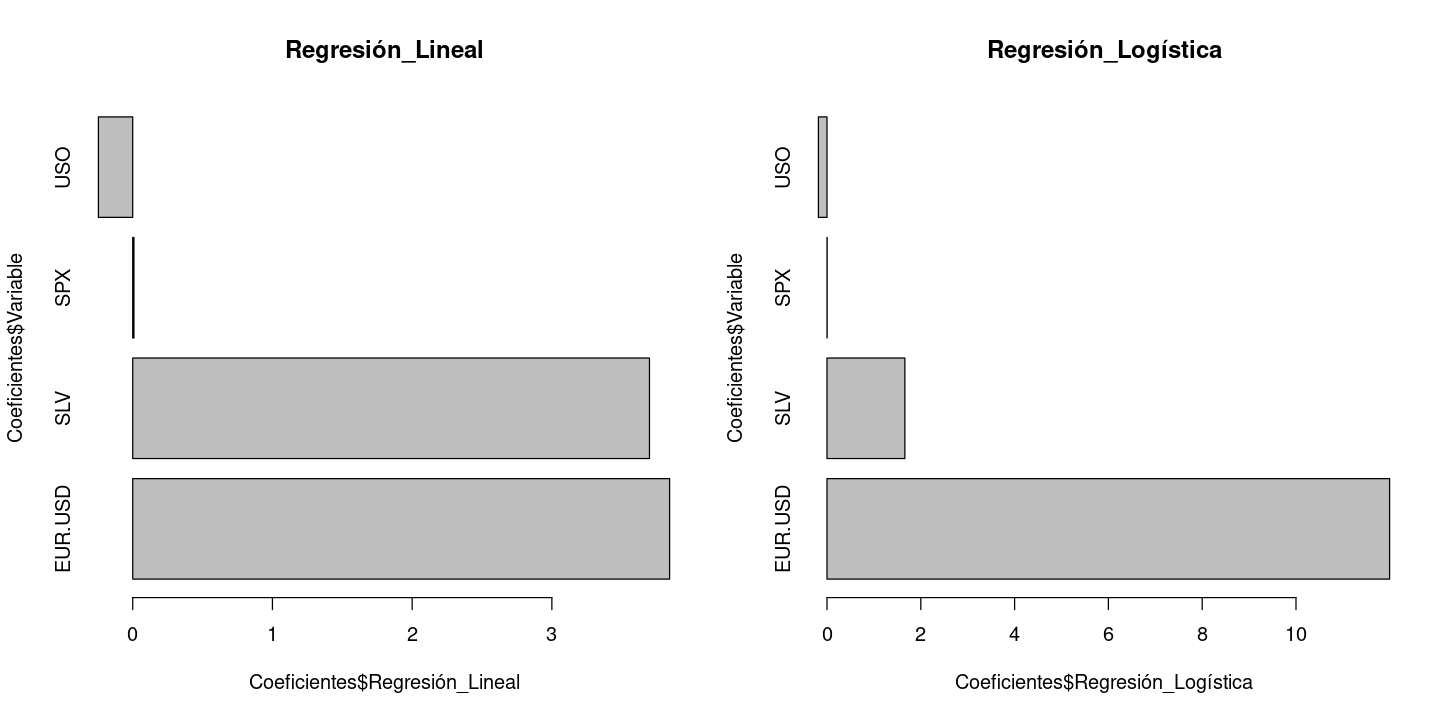

In [49]:
par(mfrow=c(1,2))
barplot(Coeficientes$Regresión_Lineal ~ Coeficientes$Variable, main="Regresión_Lineal",horiz = TRUE)
barplot(Coeficientes$Regresión_Logística ~ Coeficientes$Variable, main="Regresión_Logística",horiz = TRUE)

### Conclusiones 

In [50]:
print('La variable que más impacta de forma positiva el precio del oro según la regresión lineal es ... ') # Completar 
print('La variable que más impacta de forma negativa el precio del oro es según la regresión lineal es ... ') # Completar 

print('La variable que más impacta de forma positiva el precio del oro según la regresión logística es ... ') # Completar 
print('La variable que más impacta de forma negativa el precio del oro es según la regresión logística es ... ') #Completar

[1] "La variable que más impacta de forma positiva el precio del oro según la regresión lineal es ... "
[1] "La variable que más impacta de forma negativa el precio del oro es según la regresión lineal es ... "
[1] "La variable que más impacta de forma positiva el precio del oro según la regresión logística es ... "
[1] "La variable que más impacta de forma negativa el precio del oro es según la regresión logística es ... "


Recuerda que las variables que impactan de forma positiva son proporcionales a la variable objetivo, es decir, si la primera variable que elegiste aumenta, el precio aumenta. Y viceversa, las variables que impactan de forma negativa son inversamente proporcionales a la variable objetivo, es decir, si la primera variable que elegiste aumenta, el precio disminuye. En el caso de una variable objetivo binaria, usando una regresión logística, lo que aumenta o disminuye es la probabilidad de que la variable objetivo sea 1.